COPY/PASTE FOR STARTER README:

## Problem Statement/Goal
 - To make a scale for creating custom monsters.

## Imports

In [16]:
# Standard Imports for all notebooks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Scraping Libraries
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from time import sleep
import re

# Web Scraping

In [3]:
def open_browser(alt_user_name = 'Thank you for your website'):
    path = '../../Garage/chromedriver'         # Path to Chromedriver
    return webdriver.Chrome(executable_path = path)

In [7]:
# Obtain HTML
browser = open_browser()
browser.get('http://www.jsigvard.com/dnd/Monsters.html')
main_table = BeautifulSoup(browser.page_source)

# Take HTML and turning it into a DF
cols = [title.text for title in main_table.find('thead').find_all('th')]
list_of_lists = []

for row in main_table.find('tbody').find_all('tr'):
    list_of_lists.append([cell.text for cell in row.find_all('td')])
df_main = pd.DataFrame(list_of_lists, columns=cols)

In [14]:
list_of_htmls = []
for row_num in range(df_main.shape[0]):# - 1):
    mon_code = df_main['Monster'][row_num].replace(" ", "%20")
    print('http://www.jsigvard.com/dnd/monster.php?m=' + mon_code)
    browser_monster.get('http://www.jsigvard.com/dnd/monster.php?m=' + mon_code)
    critter = BeautifulSoup(browser_monster.page_source)
    list_of_htmls.append(critter.find('div', attrs = {'class' : "container"}))

http://www.jsigvard.com/dnd/monster.php?m=Aarakocra


NameError: name 'browser_monster' is not defined

In [341]:
# Turning the list of html's into list of dictionaries
list_of_mons = []
count = 0
for mons_html in list_of_htmls:
    if len(mons_html) > 5:
        # Splitting the html & init-ing the mon's dict
        stats = re.findall(r'^[^@]+999999',str(mons_html))
        stats = BeautifulSoup(stats[0])
        moves = re.findall(r'clipboard[^@]+',str(mons_html))
        moves = BeautifulSoup(moves[0])
        mon_dict = {}

        # Obtaining Qualitative Stats
        for quality in stats.find_all('span'):
            mon_dict['Name'] = stats.find('h2').text
            key = quality.find('b')
            val = re.findall(r'\/b>.+<',str(quality))
            if key is not None:
                mon_dict[key.text] = val[0].strip('<').strip('/b> ')

        # Obtaining Numerical Stats
        stat_list = stats.find('table').find_all('td')
        mon_dict["STR"] = stat_list[6].text
        mon_dict["DEX"] = stat_list[7].text
        mon_dict["CON"] = stat_list[8].text
        mon_dict["INT"] = stat_list[9].text
        mon_dict["WIS"] = stat_list[10].text
        mon_dict["CHA"] = stat_list[11].text
        mon_dict['Challenge'] = re.findall(r'Challenge.+<br/>',
                                    str(stats))[0].strip('<br/><br/>').strip('Challenge</b> ')

        # Obtaining Moves and actions
        atk_count = 1
        for attack in moves.find_all('a', attrs = {'class':'attack'}):
            move = attack.find_all('b')[0].text.strip('.')
            text = re.findall(r'<\/b>[^@]+<\/a>',str(attack))[0].strip('</a>')
            text = str(BeautifulSoup(text).text).strip('br> ').strip('\n')
            mon_dict['atk_move_' + str(atk_count)] = move + ' : ' + text
            #attacks[move] = text
        #mon_dict['attacks&moves'] = attacks

        list_of_mons.append(mon_dict)
    else:
        pass
    count += 1
    
df = pd.DataFrame(list_of_mons)

In [345]:
df.to_csv('./data/monsters_dataframe.csv', index= False)

In [346]:
test_df_saved = pd.read_csv('./data/monsters_dataframe.csv')

In [356]:
# Just to make it easier to find 
df_attacks = pd.DataFrame(list(df['attacks&moves']))
df_attacks.to_csv('./data/attacks.csv', index = False)

# Cleaning

In [362]:
df = df.reindex(['Name','Armor Class', 'Hit Points', 'Speed',
    'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA',  
    'Saving Throws', 'Skills', 
    'Damage Immunities', 'Damage Resistances', 'Damage Vulnerabilities', 'Condition Immunities',
    'Senses', 'Languages', 'Challenge', 'attacks&moves'], axis = 1, )

What does this mean for them to not have this listed?
Saving throws: They don't have a bonus on any specific saving throws
Skills: Then they only have their ability score if they try to do that thing
Senses: Passive Perception is WIS Mod
Languages: Can't speak or understand language


climbing : base movement rate is 30 ft (if no swim speed needs athletic check to swim) pasing is difficult terrain, otherwise can't move
if succeed then half movement speed, fail is can't do.

## Removing and fixing specific Rows

In [96]:
df.drop(47, inplace = True)

df.drop(190, inplace=True)

df.loc[153, 'CON'] = 12

## Filling Nans

In [370]:
df['Damage Vulnerabilities'].fillna("None", inplace = True)

df['Condition Immunities'].fillna("None", inplace = True)

df['Damage Immunities'].fillna("None", inplace = True)

df['Damage Resistances'].fillna("None", inplace = True)

## Re-orenting the values into Intigers

In [425]:
def map_funct(cell):
    return int(cell.split(' ')[0])
df['STR'] = df['STR'].map(lambda x: map_funct(x))
df['DEX'] = df['DEX'].map(lambda x: map_funct(x))
df['CON'] = df['CON'].map(lambda x: map_funct(x))
df['INT'] = df['INT'].map(lambda x: map_funct(x))
df['WIS'] = df['WIS'].map(lambda x: map_funct(x))
df['CHA'] = df['CHA'].map(lambda x: map_funct(x))

In [390]:
def map_funct(cell):
    try:
        cell = cell.split(' ')[1].strip('(').strip(')')
    except:
        cell = 'None'
    return cell
df['Hit Dice'] = df['Hit Points'].map(lambda x: map_funct(x))

In [393]:
def map_funct(cell):
    try:
        cell = cell.split(' ')[0]
    except:
        cell = cell
    return int(cell)
df['Hit Points'] = df['Hit Points'].map(lambda x: map_funct(x))

In [404]:
def map_funct(cell):
    try:
        cell = cell.split(' (')[1].strip(')')
    except:
        cell = 'None'
    return cell
df['Armor Note'] = df['Armor Class'].map(lambda x: map_funct(x))

In [406]:
def map_funct(cell):
    try:
        cell = cell.split(' (')[0]
    except:
        cell = 'None'
    return int(cell)
df['Armor Class'] = df['Armor Class'].map(lambda x: map_funct(x))

In [88]:
def map_funct(cell):
    try:
        cell = cell.split(' (')[0]
        if len(cell) > 1 and cell[1] == "/":
            cell = cell.split('/') 
            cell = int(cell[0]) / int(cell[1])
    except:
        cell = 0
    return float(cell)
df['Challenge'] = df['Challenge'].map(lambda x: map_funct(x))

|Score   |1 |2–3|4–5|6–7|8–9|10–11|12–13|14–15|16–17|18–19|20–21|22–23|24–25|26–27|28–29|30 |
|--------|--|---|---|---|---|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|---|
|Modifier|−5|−4 |−3 |−2 |−1 |+0   |+1   |+2   |+3   |+4   |+5   |+6   |+7   |+8   |+9   |+10|



# Exploritory Data Analysis

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


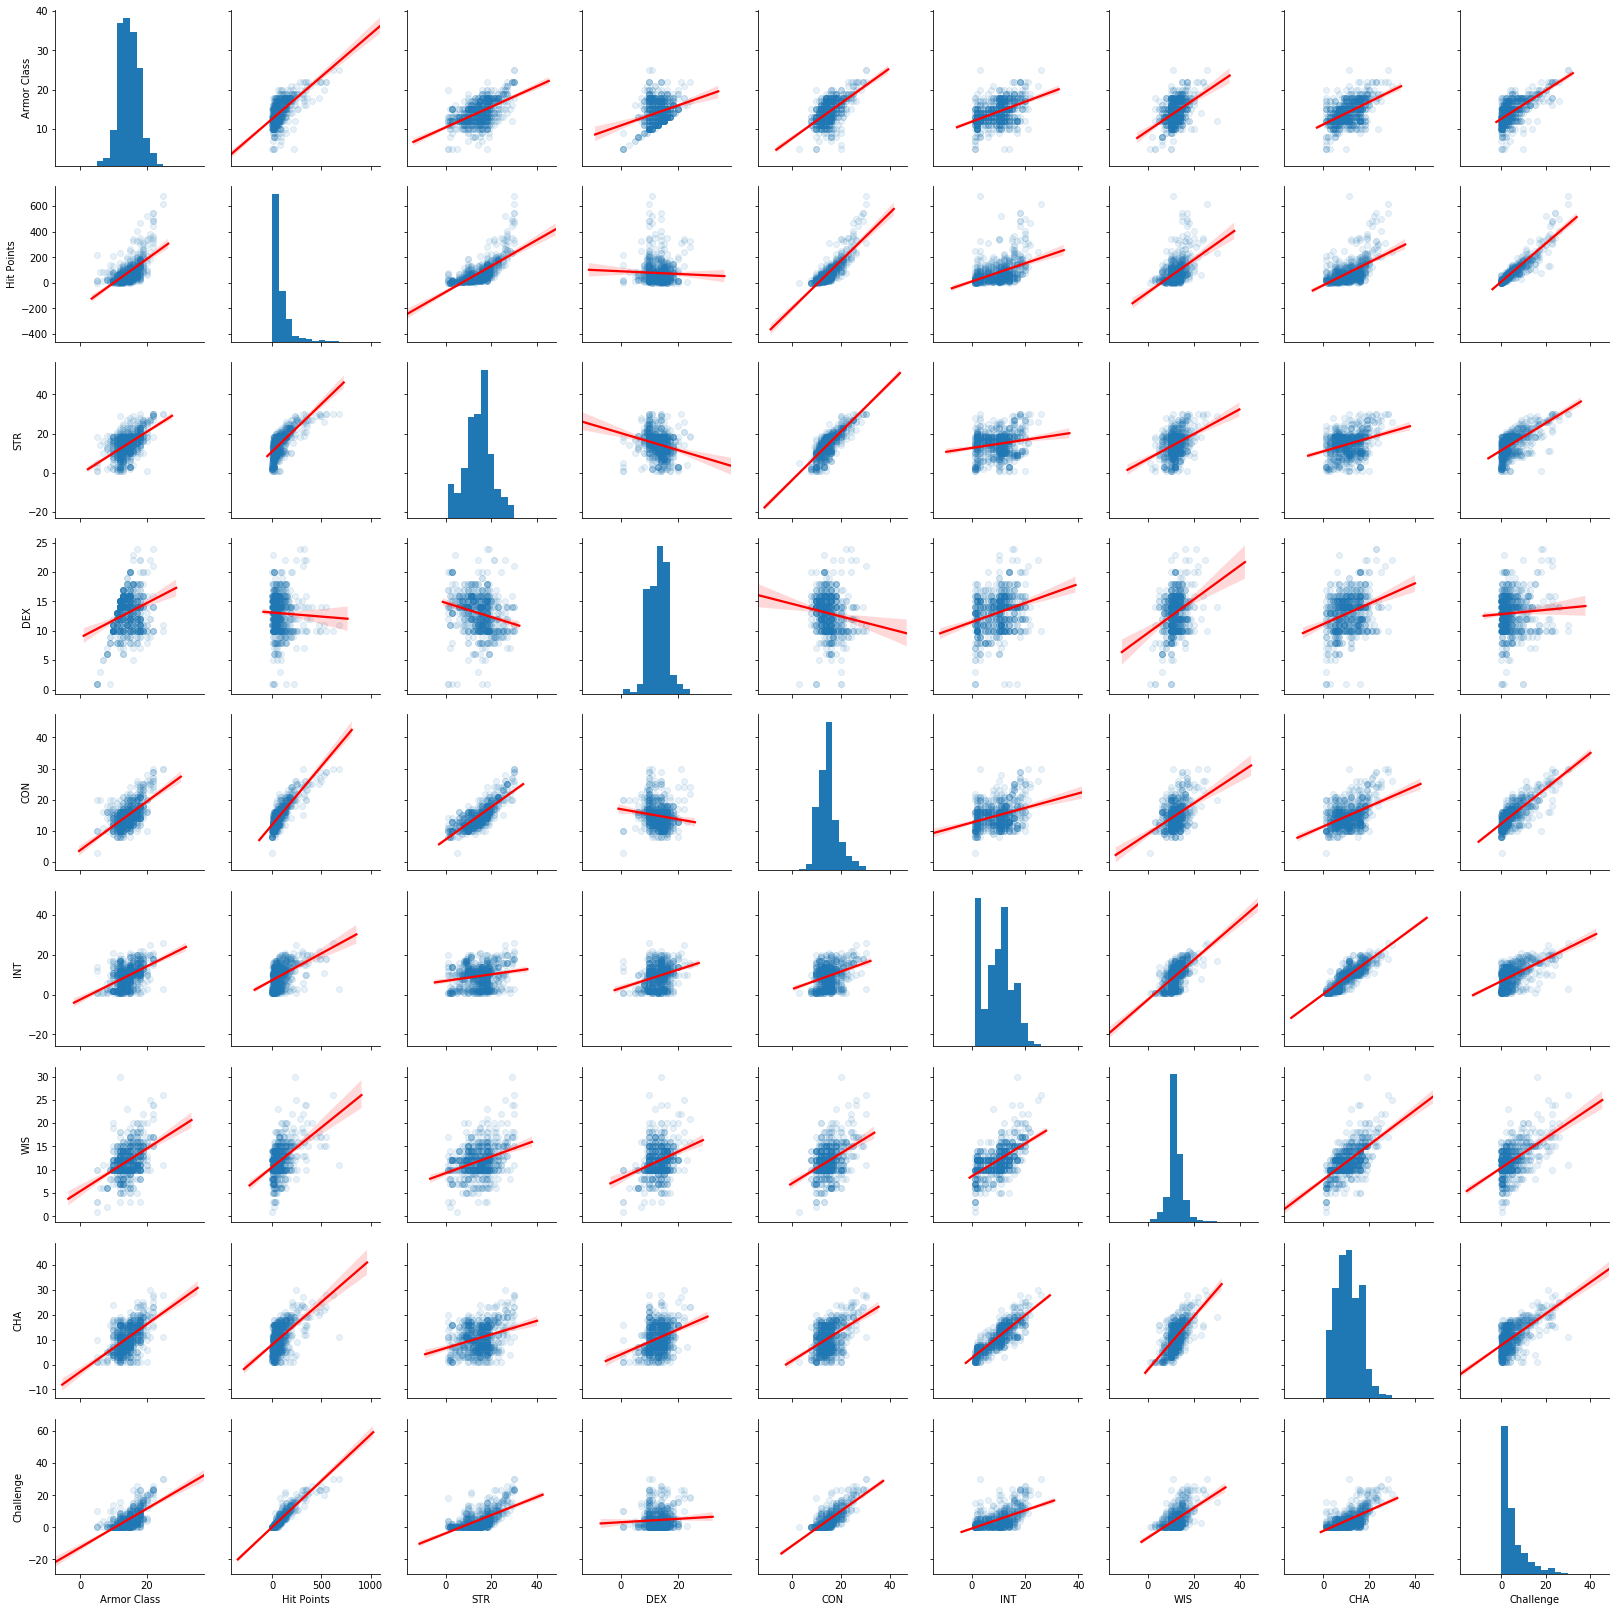

In [103]:
#df.dtypes
df_nums = pd.DataFrame(df[['Armor Class', 'Hit Points','STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA', 'Challenge']])
sns.pairplot(df_nums, kind = "reg", plot_kws = {'line_kws' : {'color' : 'red'}, 'scatter_kws' : {'alpha' : 0.1}})

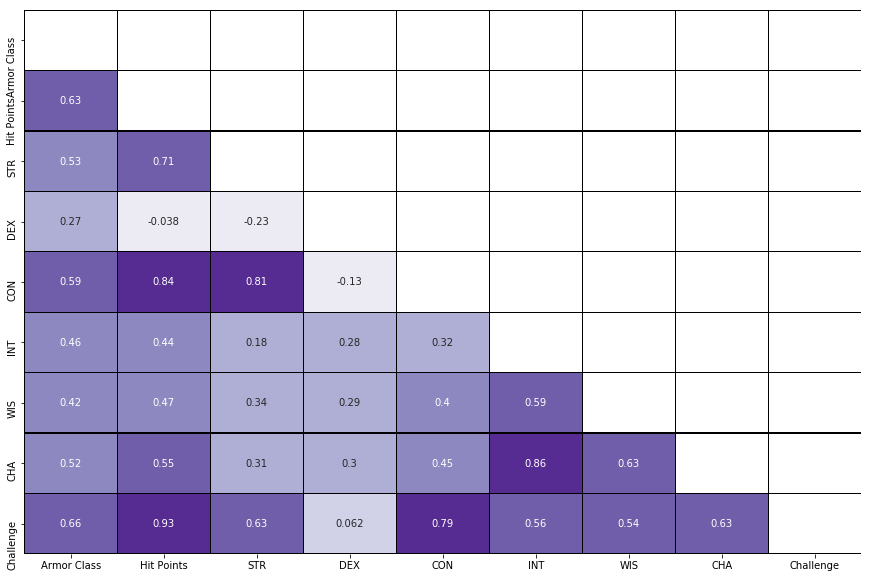

In [98]:
df_cor          = df.corr() 
# Dropped because nothing is signifigantly correlated to them
list_half_inner = []
list_half_outer = []

# Creating a blank-ish DF with the dementions that match the correlation matrix.
for i in range(df_cor.shape[0]):
    list_half_inner.append(True)
    list_half_outer.append(list_half_inner)
mask_half = pd.DataFrame(list_half_outer, columns= df_cor.columns, index=df_cor.columns)

# Turning it into a mask and cutting it in half.
for num in range(mask_half.shape[1]):
    mask_half.iloc[num,num:mask_half.shape[1]] = False

plt.figure(figsize=(15,10))

sns.heatmap(df_cor[mask_half],
            annot = True, cbar=False, 
            linewidths= .01, linecolor='black', cmap=sns.color_palette("Purples"));


# Modeling

In [107]:
### Standard Model Imports
# Model Prep
from sklearn.model_selection import train_test_split, cross_val_score

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor

# Nieve Bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB # Check notes on these

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [146]:
list_number_cols = ['Armor Class', 'Hit Points', 'STR', 'DEX', 'CON',
       'INT', 'WIS', 'CHA','Challenge']
X = df[['Armor Class', 'Hit Points', 'STR', 'DEX', 'CON',
       'INT', 'WIS', 'CHA']]
y = df['Challenge']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
print(model_lr.score(X_train, y_train))
print(model_lr.score(X_test, y_test))

0.8944486481032925
0.8934200880050465


In [145]:
list_number_cols = ['Armor Class', 'Hit Points', 'STR', 'DEX', 'CON',
       'INT', 'WIS', 'CHA','Challenge']
for i in range(len(list_number_cols)):
    col_name = list_number_cols[i]
    print('-----------------------')
    print(col_name)
    #print(df[col_name].value_counts())
    y = df[col_name]
    X = df[list_number_cols[:i] + list_number_cols[i+1:]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=76)
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    print(model_lr.score(X_train, y_train))
    print(model_lr.score(X_test, y_test))

-----------------------
Armor Class
0.5796436741013775
0.5255608726571614
-----------------------
Hit Points
0.8923650709156044
0.9247550602523973
-----------------------
STR
0.70033340702803
0.7348781776598229
-----------------------
DEX
0.37230702823266454
0.36654628778484066
-----------------------
CON
0.8076085678447205
0.8060966079303991
-----------------------
INT
0.793255156186332
0.6572573626531033
-----------------------
WIS
0.512877715020212
0.3702905988310937
-----------------------
CHA
0.8064799154473523
0.7283647404831466
-----------------------
Challenge
0.8865308371374349
0.9156663452327832


In [150]:
df['Skills']

0                                          Perception +5
1                                  Arcana +8, History +8
2                            History +12, Perception +10
3                              Perception +5, Stealth +4
4                               Medicine +4, Religion +2
5                             Perception +11, Stealth +7
6                             Perception +12, Stealth +5
7                             Perception +12, Stealth +5
8      History +7, Perception +11, Persuasion +8, Ste...
9                 Insight +7, Perception +12, Stealth +5
10              Deception +8, Perception +12, Stealth +6
11     Insight +8, Perception +14, Persuasion +13, St...
12     Deception +8, Insight +7, Perception +12, Pers...
13                            Perception +13, Stealth +6
14     Arcana +8, History +8, Perception +11, Stealth +5
15                            Perception +11, Stealth +5
16                  Arcana +6, History +6, Perception +3
17                             

In [152]:
df['Saving Throws']

0                                    NaN
1                         Int +8, Wis +5
2                 Con +6, Int +8, Wis +6
3                                    NaN
4                                    NaN
5        Dex +7, Con +10, Wis +6, Cha +8
6        Dex +5, Con +11, Wis +7, Cha +9
7        Dex +5, Con +11, Wis +7, Cha +9
8        Dex +5, Con +10, Wis +6, Cha +8
9        Dex +5, Con +11, Wis +7, Cha +9
10       Dex +6, Con +10, Wis +7, Cha +8
11      Dex +8, Con +13, Wis +8, Cha +13
12       Dex +6, Con +10, Wis +7, Cha +8
13      Dex +6, Con +13, Wis +7, Cha +11
14      Dex +5, Con +12, Wis +6, Cha +10
15       Dex +5, Con +11, Wis +6, Cha +6
16                                   NaN
17                                   NaN
18                                   NaN
19        Con +7, Int +8, Wis +7, Cha +7
20                                   NaN
21                                   NaN
22      Dex +9, Con +14, Wis +9, Cha +11
23     Dex +7, Con +15, Wis +10, Cha +12
24      Dex +6, 

,Monster,Size,Type,Alignment,CR,Source
0,Aarakocra,Medium,Humanoid (aarakocra),Neutral Good,cr0.25 cr1/41/4,Monster Manual
1,Abjurer,Medium,Humanoid (any Race),Any Alignment,cr9/19,Volo's Guide to Monsters
2,Aboleth,Large,Aberration,Lawful Evil,cr10/110,Monster Manual
3,Abominable Yeti,Huge,Monstrosity,Chaotic Evil,cr9/19,Monster Manual
4,Acolyte,Medium,Humanoid (any Race),Any Alignment,cr0.25 cr1/41/4,Monster Manual
5,Adult Black Dragon,Huge,Dragon,Chaotic Evil,cr14/114,Monster Manual
6,Adult Blue Dracolich,Huge,Undead,Lawful Evil,cr17/117,Monster Manual
7,Adult Blue Dragon,Huge,Dragon,Lawful Evil,cr16/116,Monster Manual
8,Adult Brass Dragon,Huge,Dragon,Chaotic Good,cr13/113,Monster Manual
9,Adult Bronze Dragon,Huge,Dragon,Lawful Good,cr15/115,Monster Manual


In [437]:
df.to_csv('./data/creatures_6_29.csv', index = False)

## Code Recycling Bin
- For when I'm not yet ready to delete certain old code.

|Score|	Modifier|
|-|---|
|1|	−5|
|2–3|	−4|
|4–5|	−3|
|6–7|	−2|
|8–9|	−1|
|10–11|	+0|
|12–13|	+1|
|14–15|	+2|
|16–17|	+3|
|18–19|	+4|
|20–21|	+5|
|22–23|	+6|
|24–25|	+7|
|26–27|	+8|
|28–29|	+9|
|30	|+10|

In [20]:
df = pd.read_csv('./data/creatures_6_29.csv')

|Challenge	     |  XP|
|----------------|----|
|0 |(10 XP)      |
|1/8|(25 XP)     |
|1/4|(50 XP)     |
|1/2|(100 XP)    |
|1 |(200 XP)     |
|2 |(450 XP)     |
|3 |(700 XP)     |
|4 |(1,100 XP)   |
|5 |(1,800 XP)   |
|6 |(2,300 XP)   |
|7 |(2,900 XP)   |
|8 |(3,900 XP)   |
|9 |(5,000 XP)   |
|10| (5,900 XP)  |
|11| (7,200 XP)  |
|12| (8,400 XP)  |
|13| (10,000 XP) |
|14| (11,500 XP) |
|15| (13,000 XP) |
|16| (15,000 XP) |
|17| (18,000 XP) |
|18| (20,000 XP) |
|19| (22,000 XP) |
|20| (25,000 XP) |
|21| (33,000 XP) |
|22| (41,000 XP) |
|23| (50,000 XP) |
|24| (62,000 XP) |
|25| (75,000 XP) |
|26| (90,000 XP) |
|30| (155,000 XP)|